### Deep Learning  Assignment
**by- ed24s401**

### ANSWER 1

Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

In [16]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ed24s401 (ed24s401-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


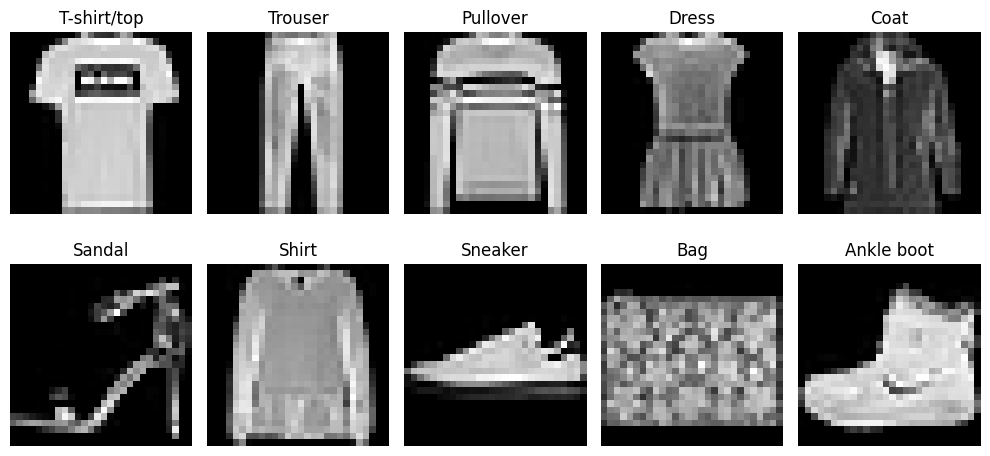

In [ ]:

wandb.init(project='fashion-MNIST dataset', name='fashion-MNIST samples')
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_lbs=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
fig, axes=plt.subplots(2,5, figsize=(10,5))
axes=axes.flatten()
marked_img=[]

for i in range(10):
    idx=np.where(y_train ==i)[0][0]
    axes[i].imshow(x_train[idx], cmap='gray')
    axes[i].set_title(class_lbs[i])
    axes[i].axis('off')
    marked_img.append(wandb.Image(x_train[idx], caption=class_lbs[i]))

plt.tight_layout() 
plt.show()
#logging figure to wandb
wandb.log({"fashion-MNIST samples": marked_img})
wandb.finish()



In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
#loading the dataset
(x_train_full, y_train_full), (x_test,y_test)=fashion_mnist.load_data()
 
# normalize images
x_train_full=x_train_full.reshape(x_train_full.shape[0], -1)/255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0
#shuffle dataset
np.random.seed(42)
indices=np.arange(x_train_full.shape[0])
np.random.shuffle(indices)

x_train_full, y_train_full=x_train_full[indices], y_train_full[indices]

# splitting the dataset into training(85%) and validation(15%)
train_size=int(.85*len(x_train_full))

x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

#converting truth(y) into one hot vector
t_classes=10
y_train_1h=np.eye(t_classes)[y_train]
y_val_1h=np.eye(t_classes)[y_val]
y_test_1h=np.eye(t_classes)[y_test]
print(len(x_test))

# print(f"Train set: {x_train.shape}, Validation set: {x_val.shape}, Test set: {x_test.shape}") #Train set: (51000, 784), Validation set: (9000, 784), Test set: (10000, 784)
# print(f"\n{y_train_1h.shape},  {y_val_1h.shape}") #(51000, 10), (9000, 10)



10000


### ANSWER 2.

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer

In [4]:

class feed_forward_NN:

    def __init__(self, layers):
        self.layers=layers
        self.weights=[]
        self.biases=[]
        self.layer_n=len(layers)

        for i in range(self.layer_n-1):
            w=np.random.randn(self.layers[i],self.layers[i+1])*np.sqrt(2/self.layers[i]) #size(self.layers[i] x self.layers[i+1])
            b=np.zeros((1,self.layers[i+1])) #size(self.layers[i] x self.layers[i+1])
            self.weights.append(w)
            self.biases.append(b)

    def sigmoid(self,x):
        return 1/ (1+np.exp(-np.clip(x, -500, 500)))
    
    def softmax(self, x):
        exp_x=np.exp(x-np.max(x, axis=1, keepdims=True))
        return exp_x/np.sum(exp_x, axis=1, keepdims=True)
        
    def sig_derivative(self, x):
        return x*(1-x)
    
    def forward_pass(self,x):
        self.h=[x]
        for i in range(self.layer_n-2):
            a=np.dot(self.h[i], self.weights[i])+ self.biases[i]
            h=self.sigmoid(a)
            self.h.append(h)
        #Output_layer  _using_softmax
        a_out=np.dot(self.h[-1],self.weights[-1]) +self.biases[-1]
        h_out=self.softmax(a_out)
        self.h.append(h_out)
        return self.h
    
    def predicted_prob_distribution(self,x):
        y_cap=self.forward_pass(x)
        return y_cap[-1]

In [17]:
hidden_layers=[128,64]
layers=[784]+hidden_layers+[10]
print(layers)

network=feed_forward_NN(layers)
predictions=network.predicted_prob_distribution(x_train_full)
print(predictions)


[784, 128, 64, 10]
[[0.17872513 0.06798745 0.14031561 ... 0.06762071 0.08305973 0.14672065]
 [0.18367809 0.0761571  0.13851677 ... 0.06825291 0.08191982 0.1487257 ]
 [0.18505874 0.07433587 0.13848236 ... 0.06651154 0.0749203  0.15048631]
 ...
 [0.16821616 0.07813909 0.14520503 ... 0.07010719 0.07921877 0.15076432]
 [0.16913051 0.08037744 0.1403648  ... 0.06633245 0.08263289 0.15581743]
 [0.17724641 0.06945173 0.13648755 ... 0.07517653 0.08473997 0.14867274]]


### ANSWER 3

Implement the backpropagation algorithm with support for the following optimisation functions

- **sgd**
- **momentum based gradient descent**
- **nesterov accelerated gradient descent**
- **rmsprop**
- **adam**
- **nadam**

In [ ]:

class feed_forward_NN_3:

    def __init__(self, layers, optimizer, learning_rate, momentum, beta1, beta2, beta_rms, epsilon):
        
        
        self.layers=layers
        self.layer_n=len(layers)
        self.optimizer= optimizer.lower()
        self.lr=learning_rate
        self.momentum=momentum
        self.beta1=beta1
        self.beta2=beta2
        self.beta_rms=beta_rms
        self.epsilon=epsilon

        self.weights=[]
        self.biases=[]
        
        

        for i in range(self.layer_n-1):
            # initialization for hidden layers
            w=np.random.randn(layers[i],layers[i+1])*np.sqrt(2.0/layers[i]) #size(self.layers[i] x self.layers[i+1])
            b=np.zeros((1,layers[i+1])) #size(self.layers[i] x self.layers[i+1])
            self.weights.append(w)
            self.biases.append(b)

        # initialization of extra parameters for diff optimizers
        self._init_optim_params()

    def _init_optim_params(self):

        # common for  momentum, NAG, Adam, etc.
        if self.optimizer in ["momentum", "nesterov", "adam", "nadam", "rmsprop"]:
            self.v_w=[np.zeros_like(w) for w in self.weights]
            self.v_b=[np.zeros_like(b) for b in self.biases]

        # RMSProp or Adam or NADam (second moment)
        # if self.optimizer in ["rmsprop","adam", "nadam"]:
        #     self.s_w = [np.zeros_like(w) for w in self.weights]
        #     self.s_b =[np.zeros_like(b) for b in self.biases]

        # Adam or Nadam ( first moment and time step)
        if self.optimizer in ["adam","nadam"]:
            self.m_w =[np.zeros_like(w) for w in self.weights]
            self.m_b =[np.zeros_like(b) for b in self.biases]
            self.t =0


    def sigmoid(self,x):
        return 1/ (1+np.exp(-np.clip(x, -500, 500)))
    
    def softmax(self, x):
        exp_x=np.exp(x-np.max(x, axis=1, keepdims=True))
        return exp_x/np.sum(exp_x, axis=1, keepdims=True)
        
    def sig_derivative(self, x):
        return x*(1-x)
    
    def forward_pass(self,x):
        self.h=[x]
        for i in range(self.layer_n-2):
            a=np.dot(self.h[i], self.weights[i])+ self.biases[i]
            h=self.sigmoid(a)
            self.h.append(h)
        #Output_layer  _using_softmax
        a_out=np.dot(self.h[-1],self.weights[-1]) +self.biases[-1]
        h_out=self.softmax(a_out)
        self.h.append(h_out)
        return self.h
    
    def backward_prop(self,y_true):
        #batch_len=len(x)
        m = y_true.shape[0]
        dw = [None] * (self.layer_n - 1)
        db = [None] * (self.layer_n - 1)

        #gradient with respect to outpur layer
        delta=self.h[-1]-y_true
        #gradient wit respect to hidden layers
        for i in reversed(range(self.layer_n-1)):
            dw[i]=np.dot(self.h[i].T, delta)/m
            db[i]=np.sum(delta,axis=0,keepdims=True)/m

            if i>0:
                delta=np.dot(delta,self.weights[i].T)*self.sig_derivative(self.h[i])

        return dw, db
    
    def _update_params(self, dw, db):

        if self.optimizer =="sgd":
            #Stochastic Gradient Descent
            for i in range(self.layer_n -1):
                self.weights[i]-= self.lr *dw[i]
                self.biases[i]-= self.lr* db[i]

        elif self.optimizer =="momentum":
            for i in range(self.layer_n -1):
                self.v_w[i]= self.momentum*self.v_w[i] +dw[i]
                self.v_b[i]= self.momentum*self.v_b[i]+db[i]

                self.weights[i]-= self.lr*self.v_w[i]
                self.biases[i] -= self.lr*self.v_b[i]               

        elif self.optimizer =="rmsprop":
            for i in range(self.layer_n-1):
                self.v_w[i] = self.beta_rms * self.v_w[i] + (1 - self.beta_rms) * (dw[i] ** 2)
                self.v_b[i] = self.beta_rms * self.v_b[i] + (1 - self.beta_rms) * (db[i] ** 2)
                self.weights[i] -= self.lr * dw[i] / (np.sqrt(self.v_w[i] )+ self.epsilon)
                self.biases[i]  -= self.lr * db[i] / (np.sqrt(self.v_b[i] )+ self.epsilon)

        elif self.optimizer == "adam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

                self.weights[i] -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        elif self.optimizer == "nadam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** (self.t+1))
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** (self.t+1))
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** (self.t+1))
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** (self.t+1))

                # final update
                grad_term_w = self.beta1 * m_w_hat + (1 - self.beta1) * dw[i] / (1 - self.beta1 ** (self.t+1))
                grad_term_b = self.beta1 * m_b_hat + (1 - self.beta1) * db[i] / (1 - self.beta1 ** (self.t+1))

                self.weights[i] -= self.lr * grad_term_w / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * grad_term_b / (np.sqrt(v_b_hat) + self.epsilon)
    
    def _train_step(self, x_batch, y_batch):
         
        if self.optimizer == "nesterov":
            # shit to look-ahead: w_look = w - momentum * v
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.momentum * self.v_w[i]
                self.biases[i]  -= self.momentum * self.v_b[i]

            # forward + backward at the look-ahead position
            self.forward_pass(x_batch)
            out = self.h[-1]
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1)) 
            dW, dB = self.backward_prop(y_batch)

            # shift back to original w_t
            for i in range(self.layer_n - 1):
                self.weights[i] += self.momentum * self.v_w[i]
                self.biases[i]  += self.momentum * self.v_b[i]

            # update velocity: u_t = beta*u_{t-1} + grad_look
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dW[i]
                self.v_b[i] = self.momentum * self.v_b[i] + dB[i]

            # final update: w_{t+1} = w_t - lr * u_t
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i]  -= self.lr * self.v_b[i]

            return loss

        else:
            # Normal forward/back
            self.forward_pass(x_batch)
            out = self.h[-1]
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))

            # Backward pass
            dw, db = self.backward_prop(y_batch)

            # Update parameters with the chosen optimizer
            self._update_params(dw, db)

            return loss

    def training(self, x_train, y_train, x_val, y_val, epochs, batch_size,wandb_project):
        wandb.init(project=wandb_project, config={
            "optimizer": self.optimizer,
            "learning_rate": self.lr,
            "momentum": self.momentum,
            "beta1": self.beta1,
            "beta2": self.beta2,
            "beta_rms": self.beta_rms,
            "epsilon": self.epsilon,
            "epochs": epochs,
            "batch_size": batch_size,
            "layers": self.layers
        })


        #n_samples=len(x_train)
        for ep in range(epochs):

            # Shuffel data
            idx=np.random.permutation(x_train.shape[0],)
            x_train_shuff=x_train[idx]
            y_train_shuff=y_train[idx]

            n_batches=len(x_train)// batch_size
            batch_no=0   
            epoch_loss=0

            for b in range(n_batches):
                start = b* batch_size
                end =start+batch_size
                x_batch=x_train_shuff[start: end]
                y_batch=y_train_shuff[start: end]

                # forward pass
                loss=self._train_step(x_batch, y_batch)
                batch_no+=1
                epoch_loss+=loss

            # average loss        
            loss_avg=epoch_loss/batch_no

            # use of validation dataset for predictions
            valid_prediction= self.predict(x_val)
            val_labels=np.argmax(y_val, axis =1)
            valid_accuracy=np.mean(valid_prediction ==val_labels)

            # loging in wandb
            wandb.log({'epoch':ep+1, 'training_loss' : loss_avg, 'validation_accuracy': valid_accuracy})
            print(f"epoch: {ep+1}/{epochs}, train_loss:{loss_avg:.5f}, val_accuracy: {valid_accuracy:.5f}")

        wandb.finish()
    

    # def predict_prob(self, x):
    #     self.forward_pass(x)
    #     return self.h[-1]

    def predict(self,x):
        y_cap=self.forward_pass(x)
        return np.argmax(y_cap[-1], axis=1)
    

if __name__=="__main__":
    optimizer_name="sgd"

    model =feed_forward_NN_3(
        layers=[784, 128, 64, 10],
        optimizer=optimizer_name,
        learning_rate=0.1,
        momentum=0.9,
        beta1=0.9,
        beta2=0.999,
        beta_rms=0.9,
        epsilon=1e-8,
    )
    model.training(
        x_train=x_train,
        y_train=y_train_1h,
        x_val=x_val,
        y_val=y_val_1h,
        epochs=10,
        batch_size=64,
        wandb_project="backpropagation framework"
    )

    test_preds = model.predict(x_test)
    test_labels = np.argmax(y_test_1h, axis=1)
    test_acc = np.mean(test_preds == test_labels)
    print("Test Accuracy:", test_acc)





epoch: 1/10, train_loss:1.19047, val_accuracy: 0.74600
epoch: 2/10, train_loss:0.64018, val_accuracy: 0.79189
epoch: 3/10, train_loss:0.54309, val_accuracy: 0.81644
epoch: 4/10, train_loss:0.49514, val_accuracy: 0.82978
epoch: 5/10, train_loss:0.46597, val_accuracy: 0.83911
epoch: 6/10, train_loss:0.44591, val_accuracy: 0.84022
epoch: 7/10, train_loss:0.43001, val_accuracy: 0.84822
epoch: 8/10, train_loss:0.41902, val_accuracy: 0.84700
epoch: 9/10, train_loss:0.40808, val_accuracy: 0.85422
epoch: 10/10, train_loss:0.39895, val_accuracy: 0.85789


epoch,▁▂▃▃▄▅▆▆▇█
training_loss,█▃▂▂▂▁▁▁▁▁
validation_accuracy,▁▄▅▆▇▇▇▇██
epoch,10
training_loss,0.39895
validation_accuracy,0.85789


Test Accuracy: 0.8453


### ANSWER 4.

In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist


# Neural Network Class: feed_forward_NN_4

class feed_forward_NN_4:
    def __init__(self,
                 layers,
                 optimizer,
                 learning_rate,
                 momentum,
                 beta1,
                 beta2,
                 beta_rms,
                 epsilon,
                 weight_decay,
                 init_type,
                 activation):
    
        
        self.layers = layers
        self.layer_n = len(layers)
        self.optimizer = optimizer.lower()
        self.lr = learning_rate
        self.momentum = momentum
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta_rms = beta_rms
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.init_type = init_type.lower()
        self.activation = activation.lower()

        # Initialize Weights & BiaseS
        self.weights = []
        self.biases = []
        for i in range(self.layer_n - 1):
            if self.init_type == "xavier":
                # "Xavier" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(1.0 / layers[i])
            else:
                # "random" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i])
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

        # initialize extra Params 
        if self.optimizer in ["momentum", "nesterov", "rmsprop", "adam", "nadam"]:
            self.v_w = [np.zeros_like(w) for w in self.weights]
            self.v_b = [np.zeros_like(b) for b in self.biases]
        if self.optimizer in ["adam", "nadam"]:
            self.m_w = [np.zeros_like(w) for w in self.weights]
            self.m_b = [np.zeros_like(b) for b in self.biases]
            self.t = 0

    # activations 
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def relu(self, x):
        return np.maximum(0, x)

    def activate(self, x):
        if self.activation == "sigmoid":
            return self.sigmoid(x)
        elif self.activation == "tanh":
            return self.tanh(x)
        elif self.activation == "relu":
            return self.relu(x)
        else:
            return self.sigmoid(x) 
        
    # derivatives
    def derivative(self, a):

        if self.activation == "sigmoid":
            return a * (1 - a)
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "relu":
            return (a > 0).astype(float)
        else:
            return a * (1 - a) 

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # Forward Pass
    def forward_pass(self, x):
        self.h = [x]  
        # Hidden layers
        for i in range(self.layer_n - 2):
            z = np.dot(self.h[i], self.weights[i]) + self.biases[i]
            act = self.activate(z)
            self.h.append(act)
        # Output layer- softmax
        z_out = np.dot(self.h[-1], self.weights[-1]) + self.biases[-1]
        out = self.softmax(z_out)
        self.h.append(out)
        return self.h

    # Backward Pass
    def backward_prop(self, y_true):
        m = y_true.shape[0]
        dw = [None] * (self.layer_n - 1)
        db = [None] * (self.layer_n - 1)

        # Cross-entropy derivative for output layer
        delta = self.h[-1] - y_true  # shape: (batch_size, output_dim)

        # Propagation
        for i in reversed(range(self.layer_n - 1)):
            dw[i] = np.dot(self.h[i].T, delta) / m
            db[i] = np.sum(delta, axis=0, keepdims=True) / m
            if i > 0:
                # For hidden layers, multiply by derivative of activation
                delta = np.dot(delta, self.weights[i].T) * self.derivative(self.h[i])
        return dw, db

    # Param Updates for "Non-Nesterov" 
    def _update_params(self, dw, db):
        # Add weight decay to each gradient
        for i in range(self.layer_n - 1):
            dw[i] += self.weight_decay * self.weights[i]

        if self.optimizer == "sgd":
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * dw[i]
                self.biases[i] -= self.lr * db[i]

        elif self.optimizer == "momentum":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dw[i]
                self.v_b[i] = self.momentum * self.v_b[i] + db[i]
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i] -= self.lr * self.v_b[i]

        elif self.optimizer == "rmsprop":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.beta_rms * self.v_w[i] + (1 - self.beta_rms) * (dw[i] ** 2)
                self.v_b[i] = self.beta_rms * self.v_b[i] + (1 - self.beta_rms) * (db[i] ** 2)
                self.weights[i] -= self.lr * dw[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
                self.biases[i]  -= self.lr * db[i] / (np.sqrt(self.v_b[i]) + self.epsilon)

        elif self.optimizer == "adam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

                self.weights[i] -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        elif self.optimizer == "nadam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** (self.t + 1))
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** (self.t + 1))
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** (self.t + 1))
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** (self.t + 1))

                grad_term_w = self.beta1 * m_w_hat + (1 - self.beta1) * dw[i] / (1 - self.beta1 ** (self.t + 1))
                grad_term_b = self.beta1 * m_b_hat + (1 - self.beta1) * db[i] / (1 - self.beta1 ** (self.t + 1))

                self.weights[i] -= self.lr * grad_term_w / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * grad_term_b / (np.sqrt(v_b_hat) + self.epsilon)

    # Training Step  with "Nesterov"
    def _train_step(self, x_batch, y_batch):
        if self.optimizer == "nesterov":
            # to look-ahead: w_look = w - momentum * v
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.momentum * self.v_w[i]
                self.biases[i]  -= self.momentum * self.v_b[i]

            # 2) Forward at the look-ahead position
            self.forward_pass(x_batch)
            out = self.h[-1]
            l2_norm_weights, l2_norm_bias = 0, 0
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            for i in range(len(self.biases)):
                l2_norm_bias += np.sum(self.biases[i] ** 2)
                    
            l2_norm_params = l2_norm_bias + l2_norm_weights
            
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            #loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)

            # add weight decay here
            for i in range(self.layer_n - 1):
                dW[i] += self.weight_decay * self.weights[i]

            # backward at the look-ahead position (go back to w_t)
            for i in range(self.layer_n - 1):
                self.weights[i] += self.momentum * self.v_w[i]
                self.biases[i]  += self.momentum * self.v_b[i]

            # update velocity: u_t = momentum*u_{t-1} + dW
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dW[i]
                self.v_b[i] = self.momentum * self.v_b[i] + dB[i]

            # final param update: w = w - lr*u_t
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i]  -= self.lr * self.v_b[i]

            return loss
        else:
            # Normal forward/back
            self.forward_pass(x_batch)
            out = self.h[-1]

            l2_norm_weights=0
            l2_norm_bias= 0
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            for i in range(len(self.biases)):
                l2_norm_bias += np.sum(self.biases[i] ** 2)
                    
            l2_norm_params = l2_norm_bias + l2_norm_weights
            
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params 

            #loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)
            self._update_params(dW, dB)
            return loss

    # Outer Training Loop 
    def training(self, x_train, y_train, x_val, y_val, epochs, batch_size):
       
        for ep in range(epochs):
            idx = np.random.permutation(x_train.shape[0])
            x_train_shuff = x_train[idx]
            y_train_shuff = y_train[idx]
            n_batches = len(x_train) // batch_size
            epoch_loss = 0.0
            for b in range(n_batches):
                start = b * batch_size
                end = start + batch_size
                x_batch = x_train_shuff[start:end]
                y_batch = y_train_shuff[start:end]
                loss = self._train_step(x_batch, y_batch)
                epoch_loss += loss
            avg_loss = epoch_loss / n_batches

            # Validation

            preds = self.predict(x_val)
            val_labels = np.argmax(y_val, axis=1)
            val_acc = np.mean(preds == val_labels)

            val_outputs = self.forward_pass(x_val)[-1]
        
            # Cross-entropy loss for validation
            val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis=1))

            # Log metrics to wandb
            wandb.log({"epoch": ep+1, "training_loss": avg_loss, "validation_accuracy": val_acc, "validation loss": val_loss})
            print(f"Epoch {ep+1}/{epochs} - loss={avg_loss:.4f}, val_acc={val_acc:.4f}")

    #Prediction 
    def predict(self, X):
        self.forward_pass(X)
        return np.argmax(self.h[-1], axis=1)


# train_sweep() function

def train_sweep():
    # Initialize wandb
    wandb.init()
    config = wandb.config

    #custom run name from hyperparameters
    run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
    wandb.run.name = run_name

    # Load Fashion-MNIST
    (x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
    x_train_full = x_train_full.reshape(x_train_full.shape[0], -1) / 255.0
    x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

    np.random.seed(42)
    idx = np.arange(x_train_full.shape[0])
    np.random.shuffle(idx)
    x_train_full = x_train_full[idx]
    y_train_full = y_train_full[idx]

    # 90% training, 10% validation 
    train_size=int(.9*len(x_train_full))

    x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
    x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

    num_classes = 10
    y_train_1h = np.eye(num_classes)[y_train]
    y_val_1h = np.eye(num_classes)[y_val]
    y_test_1h = np.eye(num_classes)[y_test]

    # model
    model = feed_forward_NN_4(
        layers=[784] + [config.hidden_size] * config.num_hidden_layers + [10],
        optimizer=config.optimizer,
        learning_rate=config.learning_rate,
        momentum=config.momentum,
        beta1=config.beta1,
        beta2=config.beta2,
        beta_rms=config.beta_rms,
        epsilon=config.epsilon,
        weight_decay=config.weight_decay,
        init_type=config.init_type,
        activation=config.activation
    )

    # Train the model
    model.training(
        x_train=x_train,
        y_train=y_train_1h,
        x_val=x_val,
        y_val=y_val_1h,
        epochs=config.epochs,
        batch_size=config.batch_size
    )

    #Evaluation on test set
    test_preds = model.predict(x_test)
    test_labels = np.argmax(y_test_1h, axis=1)
    test_acc = np.mean(test_preds == test_labels)
    wandb.log({"test_accuracy": test_acc})


# sweep configuration
sweep_config = {
    "method": "random", 
    "metric": {
        "name": "validation_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {"values": [5, 10]},
        "num_hidden_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0.0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "init_type": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]},
        "momentum": {"values": [0.8, 0.9]},
        "beta1": {"values": [0.9]},
        "beta2": {"values": [0.999]},
        "beta_rms": {"values": [0.9]},
        "epsilon": {"values": [1e-8]}
    }
}

# Running the sweep

if __name__ == "__main__":
    # Creating sweep
    sweep_id = wandb.sweep(sweep_config, project="q4_sweep_project")
    # Launching sweep agent
    wandb.agent(sweep_id, function=train_sweep)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: gqgcpa17
Sweep URL: https://wandb.ai/ed24s401-indian-institute-of-technology-madras/q4_sweep_project/sweeps/gqgcpa17


wandb: Agent Starting Run: 83aiinh2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: Currently logged in as: ed24s401 (ed24s401-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/5 - loss=0.5944, val_acc=0.8253
Epoch 2/5 - loss=0.4763, val_acc=0.8598
Epoch 3/5 - loss=0.4491, val_acc=0.8610
Epoch 4/5 - loss=0.4341, val_acc=0.8633
Epoch 5/5 - loss=0.4273, val_acc=0.8680


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▇▇▇█
epoch,5
test_accuracy,0.8599
training_loss,0.42729
validation loss,0.35778
validation_accuracy,0.868


wandb: Agent Starting Run: tfvpjrxz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=1.8270, val_acc=0.5407
Epoch 2/10 - loss=1.0680, val_acc=0.6717
Epoch 3/10 - loss=0.8412, val_acc=0.7118
Epoch 4/10 - loss=0.7200, val_acc=0.7438
Epoch 5/10 - loss=0.6426, val_acc=0.7748
Epoch 6/10 - loss=0.5933, val_acc=0.7850
Epoch 7/10 - loss=0.5586, val_acc=0.7975
Epoch 8/10 - loss=0.5332, val_acc=0.8055
Epoch 9/10 - loss=0.5132, val_acc=0.8120
Epoch 10/10 - loss=0.4963, val_acc=0.8185


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▂▁▁▁▁
validation loss,█▅▄▃▂▂▁▁▁▁
validation_accuracy,▁▄▅▆▇▇▇███
epoch,10
test_accuracy,0.8095
training_loss,0.49629
validation loss,0.50604
validation_accuracy,0.8185


wandb: Agent Starting Run: qbgz1mco with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.3885, val_acc=0.1925
Epoch 2/10 - loss=2.0799, val_acc=0.2880
Epoch 3/10 - loss=1.8731, val_acc=0.4667
Epoch 4/10 - loss=1.7330, val_acc=0.5412
Epoch 5/10 - loss=1.6169, val_acc=0.5537
Epoch 6/10 - loss=1.5089, val_acc=0.5652
Epoch 7/10 - loss=1.4331, val_acc=0.5728
Epoch 8/10 - loss=1.3589, val_acc=0.5778
Epoch 9/10 - loss=1.2975, val_acc=0.5845
Epoch 10/10 - loss=1.2338, val_acc=0.5887


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▆▅▄▃▃▂▂▁▁
validation loss,█▇▅▄▃▃▂▂▁▁
validation_accuracy,▁▃▆▇▇█████
epoch,10
test_accuracy,0.5944
training_loss,1.23384
validation loss,1.10687
validation_accuracy,0.58867


wandb: Agent Starting Run: r6uycor7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=1.4312, val_acc=0.5622
Epoch 2/10 - loss=0.8545, val_acc=0.6863
Epoch 3/10 - loss=0.6256, val_acc=0.8077
Epoch 4/10 - loss=0.4948, val_acc=0.8267
Epoch 5/10 - loss=0.4469, val_acc=0.8320
Epoch 6/10 - loss=0.4185, val_acc=0.8493
Epoch 7/10 - loss=0.3970, val_acc=0.8523
Epoch 8/10 - loss=0.3793, val_acc=0.8583
Epoch 9/10 - loss=0.3680, val_acc=0.8613
Epoch 10/10 - loss=0.3575, val_acc=0.8598


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▁▁▁▁▁
validation loss,█▅▃▂▂▁▁▁▁▁
validation_accuracy,▁▄▇▇▇█████
epoch,10
test_accuracy,0.8535
training_loss,0.35753
validation loss,0.40969
validation_accuracy,0.85983


wandb: Agent Starting Run: 1avpg3w7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=20.7525, val_acc=0.0977
Epoch 2/5 - loss=2.3550, val_acc=0.0977
Epoch 3/5 - loss=2.3362, val_acc=0.0977
Epoch 4/5 - loss=2.3359, val_acc=0.0977
Epoch 5/5 - loss=2.3395, val_acc=0.0977


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▁▁▅██
validation_accuracy,▁▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,2.33949
validation loss,2.30261
validation_accuracy,0.09767


wandb: Agent Starting Run: jvkof1m0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.6811, val_acc=0.6628
Epoch 2/5 - loss=1.0825, val_acc=0.7213
Epoch 3/5 - loss=0.9076, val_acc=0.7498
Epoch 4/5 - loss=0.8133, val_acc=0.7800
Epoch 5/5 - loss=0.7522, val_acc=0.7960


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▄▆▇█
epoch,5
test_accuracy,0.7962
training_loss,0.75215
validation loss,0.57684
validation_accuracy,0.796


wandb: Agent Starting Run: p1eg7w2g with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/5 - loss=2.4479, val_acc=0.1023
Epoch 2/5 - loss=2.3532, val_acc=0.1013
Epoch 3/5 - loss=2.3294, val_acc=0.1855
Epoch 4/5 - loss=2.3203, val_acc=0.1825
Epoch 5/5 - loss=2.3180, val_acc=0.0992


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▁▁▁▁
validation_accuracy,▁▁██▁
epoch,5
test_accuracy,0.1014
training_loss,2.31796
validation loss,2.30217
validation_accuracy,0.09917


wandb: Agent Starting Run: nib5s7vj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.3058, val_acc=0.1013
Epoch 2/10 - loss=2.3019, val_acc=0.1232
Epoch 3/10 - loss=2.2991, val_acc=0.2438
Epoch 4/10 - loss=2.2908, val_acc=0.1130
Epoch 5/10 - loss=2.2284, val_acc=0.2250
Epoch 6/10 - loss=1.8292, val_acc=0.2603
Epoch 7/10 - loss=1.6480, val_acc=0.3740
Epoch 8/10 - loss=1.4843, val_acc=0.4383
Epoch 9/10 - loss=1.3347, val_acc=0.4612
Epoch 10/10 - loss=1.2410, val_acc=0.5398


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,████▇▅▄▃▂▁
validation loss,████▇▄▃▂▂▁
validation_accuracy,▁▁▃▁▃▄▅▆▇█
epoch,10
test_accuracy,0.5349
training_loss,1.24101
validation loss,1.20959
validation_accuracy,0.53983


wandb: Agent Starting Run: jdakgfj4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=674891683269187133255414993895608299902937309095702553856145176288719071338620176126701142529564399608547405188899852216794156489290193955717120.0000, val_acc=0.0977
Epoch 2/5 - loss=24408223952587741067837310711936411033501127265566710290074860297204327500807458303956465467569721770187731037192228925574423442034795195924480.0000, val_acc=0.0977
Epoch 3/5 - loss=24001705904371591470748702287681301593038513013691997323101438126072705338695901833670142065990873486676512013598726363169974148764440494866432.0000, val_acc=0.1013
Epoch 4/5 - loss=23601958398897402297536648370825258881566159657296866977150861798303201999583497394445922112501496947570400440973357305140366895508649832087552.0000, val_acc=0.0995
Epoch 5/5 - loss=23208868673031544122838952559368200598292340555915485737394225030465904208943678981727965919107226002144048314611444524860266801782817709621248.0000, val_acc=0.0995


epoch,▁▃▅▆█
test_accuracy,▁
validation loss,█▆▁▄▄
validation_accuracy,▁▁█▅▅
epoch,5
test_accuracy,0.1
training_loss,2.3208868673031544e+142
validation loss,2.30263
validation_accuracy,0.0995


wandb: Agent Starting Run: s4lokpyl with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=0.4978, val_acc=0.8560
Epoch 2/10 - loss=0.3772, val_acc=0.8585
Epoch 3/10 - loss=0.3419, val_acc=0.8590
Epoch 4/10 - loss=0.3170, val_acc=0.8740
Epoch 5/10 - loss=0.3002, val_acc=0.8742
Epoch 6/10 - loss=0.2878, val_acc=0.8840
Epoch 7/10 - loss=0.2724, val_acc=0.8813
Epoch 8/10 - loss=0.2637, val_acc=0.8868
Epoch 9/10 - loss=0.2539, val_acc=0.8783
Epoch 10/10 - loss=0.2450, val_acc=0.8835


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▅▄▃▃▂▂▂▁▁
validation loss,█▆▇▃▂▁▂▂▄▂
validation_accuracy,▁▂▂▅▅▇▇█▆▇
epoch,10
test_accuracy,0.8823
training_loss,0.24502
validation loss,0.32374
validation_accuracy,0.8835


wandb: Agent Starting Run: 4om89a8z with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1/5 - loss=1.1836, val_acc=0.7455
Epoch 2/5 - loss=0.6137, val_acc=0.8028
Epoch 3/5 - loss=0.5128, val_acc=0.8168
Epoch 4/5 - loss=0.4710, val_acc=0.8338
Epoch 5/5 - loss=0.4442, val_acc=0.8458


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▅▆▇█
epoch,5
test_accuracy,0.8396
training_loss,0.44419
validation loss,0.43948
validation_accuracy,0.84583


wandb: Agent Starting Run: ne1q8buk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=5.5733, val_acc=0.1018
Epoch 2/5 - loss=2.3203, val_acc=0.1023
Epoch 3/5 - loss=2.3205, val_acc=0.0985
Epoch 4/5 - loss=2.3212, val_acc=0.0985
Epoch 5/5 - loss=2.3242, val_acc=0.1013


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▂▁█▅▆
validation_accuracy,▇█▁▁▆
epoch,5
test_accuracy,0.1
training_loss,2.32419
validation loss,2.3027
validation_accuracy,0.10133


wandb: Agent Starting Run: t32if31x with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.3560, val_acc=0.1378
Epoch 2/5 - loss=2.3340, val_acc=0.1503
Epoch 3/5 - loss=2.3111, val_acc=0.1705
Epoch 4/5 - loss=2.2836, val_acc=0.1945
Epoch 5/5 - loss=2.2506, val_acc=0.2193


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▇▅▃▁
validation loss,█▇▅▃▁
validation_accuracy,▁▂▄▆█
epoch,5
test_accuracy,0.215
training_loss,2.25062
validation loss,2.16815
validation_accuracy,0.21933


wandb: Agent Starting Run: nqwecnan with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.9537, val_acc=0.7895
Epoch 2/5 - loss=0.5596, val_acc=0.8208
Epoch 3/5 - loss=0.4959, val_acc=0.8405
Epoch 4/5 - loss=0.4672, val_acc=0.8455
Epoch 5/5 - loss=0.4480, val_acc=0.8552


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▄▆▇█
epoch,5
test_accuracy,0.8472
training_loss,0.44795
validation loss,0.4046
validation_accuracy,0.85517


wandb: Agent Starting Run: jv28qzxj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.2130, val_acc=0.3943
Epoch 2/5 - loss=1.7605, val_acc=0.5098
Epoch 3/5 - loss=1.2952, val_acc=0.6693
Epoch 4/5 - loss=1.0024, val_acc=0.7073
Epoch 5/5 - loss=0.8747, val_acc=0.7317


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▆▃▂▁
validation loss,█▅▃▂▁
validation_accuracy,▁▃▇▇█
epoch,5
test_accuracy,0.7253
training_loss,0.8747
validation loss,0.78295
validation_accuracy,0.73167


wandb: Agent Starting Run: 6sr1oy55 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


C:\Users\acer\AppData\Local\Temp\ipykernel_20856\2558324934.py:202: RuntimeWarning: overflow encountered in square
  l2_norm_weights += np.sum(self.weights[i] ** 2)
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\acer\AppData\Local\Temp\ipykernel_20856\2558324934.py:204: RuntimeWarning: overflow encountered in square
  l2_norm_bias += np.sum(self.biases[i] ** 2)
C:\Users\acer\AppData\Local\Temp\ipykernel_20856\2558324934.py:208: RuntimeWarning: invalid value encountered in scalar multiply
  loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow


Epoch 1/5 - loss=nan, val_acc=0.0977
Epoch 2/5 - loss=nan, val_acc=0.0977
Epoch 3/5 - loss=nan, val_acc=0.0977
Epoch 4/5 - loss=nan, val_acc=0.0977
Epoch 5/5 - loss=nan, val_acc=0.0977


epoch,▁▃▅▆█
test_accuracy,▁
validation_accuracy,▁▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,nan
validation loss,nan
validation_accuracy,0.09767


wandb: Agent Starting Run: aa29o0ue with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.5471, val_acc=0.6945
Epoch 2/5 - loss=0.9051, val_acc=0.7468
Epoch 3/5 - loss=0.7750, val_acc=0.7758
Epoch 4/5 - loss=0.7109, val_acc=0.7932
Epoch 5/5 - loss=0.6698, val_acc=0.8043


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▄▆▇█
epoch,5
test_accuracy,0.8041
training_loss,0.6698
validation loss,0.56145
validation_accuracy,0.80433


wandb: Agent Starting Run: req3o5jg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=3.7490, val_acc=0.0995
Epoch 2/5 - loss=2.3765, val_acc=0.1013
Epoch 3/5 - loss=2.4350, val_acc=0.0995
Epoch 4/5 - loss=2.4827, val_acc=0.1000
Epoch 5/5 - loss=2.5819, val_acc=0.0995


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▂▂
validation loss,▁▁█▄▃
validation_accuracy,▁█▁▃▁
epoch,5
test_accuracy,0.1
training_loss,2.58192
validation loss,2.30268
validation_accuracy,0.0995


wandb: Agent Starting Run: razdvgd9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=18.5253, val_acc=0.1018
Epoch 2/10 - loss=2.4384, val_acc=0.1013
Epoch 3/10 - loss=2.3312, val_acc=0.0985
Epoch 4/10 - loss=2.3510, val_acc=0.0977
Epoch 5/10 - loss=2.4100, val_acc=0.1013
Epoch 6/10 - loss=2.5086, val_acc=0.1000
Epoch 7/10 - loss=2.6684, val_acc=0.1013
Epoch 8/10 - loss=2.8796, val_acc=0.1013
Epoch 9/10 - loss=3.1597, val_acc=0.1018
Epoch 10/10 - loss=3.5088, val_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▂
validation loss,▃▂█▃▅▂▁▂▂▄
validation_accuracy,█▇▂▁▇▅▇▇█▅
epoch,10
test_accuracy,0.1
training_loss,3.50877
validation loss,2.30315
validation_accuracy,0.1


wandb: Agent Starting Run: 394msr4o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=2.3272, val_acc=0.2005
Epoch 2/10 - loss=1.8467, val_acc=0.2323
Epoch 3/10 - loss=1.7054, val_acc=0.3417
Epoch 4/10 - loss=1.5514, val_acc=0.4738
Epoch 5/10 - loss=1.3763, val_acc=0.5240
Epoch 6/10 - loss=1.2754, val_acc=0.5520
Epoch 7/10 - loss=1.2074, val_acc=0.5760
Epoch 8/10 - loss=1.1525, val_acc=0.5953
Epoch 9/10 - loss=1.1084, val_acc=0.6218
Epoch 10/10 - loss=1.0715, val_acc=0.6745


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▅▅▄▃▂▂▁▁▁
validation loss,█▆▅▄▃▂▂▂▁▁
validation_accuracy,▁▁▃▅▆▆▇▇▇█
epoch,10
test_accuracy,0.6798
training_loss,1.07148
validation loss,0.94128
validation_accuracy,0.6745


wandb: Agent Starting Run: ary9v7k3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=26.5123, val_acc=0.0985
Epoch 2/5 - loss=3.1320, val_acc=0.1000
Epoch 3/5 - loss=2.3329, val_acc=0.1013
Epoch 4/5 - loss=2.3052, val_acc=0.0995
Epoch 5/5 - loss=2.3040, val_acc=0.0995


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▅▄▁▅█
validation_accuracy,▁▅█▃▃
epoch,5
test_accuracy,0.1
training_loss,2.30402
validation loss,2.30266
validation_accuracy,0.0995


wandb: Agent Starting Run: 5grujibl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=0.6865, val_acc=0.8462
Epoch 2/10 - loss=0.4657, val_acc=0.8573
Epoch 3/10 - loss=0.4290, val_acc=0.8637
Epoch 4/10 - loss=0.4094, val_acc=0.8630
Epoch 5/10 - loss=0.3964, val_acc=0.8708
Epoch 6/10 - loss=0.3852, val_acc=0.8668
Epoch 7/10 - loss=0.3784, val_acc=0.8737
Epoch 8/10 - loss=0.3716, val_acc=0.8710
Epoch 9/10 - loss=0.3657, val_acc=0.8750
Epoch 10/10 - loss=0.3606, val_acc=0.8770


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▂▂▂▂▁▁▁▁
validation loss,█▅▄▃▃▃▁▂▁▁
validation_accuracy,▁▄▅▅▇▆▇▇██
epoch,10
test_accuracy,0.872
training_loss,0.36063
validation loss,0.33186
validation_accuracy,0.877


wandb: Agent Starting Run: bhri30mj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.0242, val_acc=0.8175
Epoch 2/10 - loss=0.6392, val_acc=0.8438
Epoch 3/10 - loss=0.5981, val_acc=0.8495
Epoch 4/10 - loss=0.5785, val_acc=0.8595
Epoch 5/10 - loss=0.5673, val_acc=0.8552
Epoch 6/10 - loss=0.5616, val_acc=0.8590
Epoch 7/10 - loss=0.5528, val_acc=0.8632
Epoch 8/10 - loss=0.5487, val_acc=0.8500
Epoch 9/10 - loss=0.5446, val_acc=0.8682
Epoch 10/10 - loss=0.5432, val_acc=0.8607


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▂▂▂▁▁▁▁▁▁
validation loss,█▄▃▂▂▂▁▃▁▂
validation_accuracy,▁▅▅▇▆▇▇▅█▇
epoch,10
test_accuracy,0.8481
training_loss,0.5432
validation loss,0.38853
validation_accuracy,0.86067


wandb: Agent Starting Run: y26cqcln with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.3051, val_acc=0.4157
Epoch 2/5 - loss=1.7153, val_acc=0.6150
Epoch 3/5 - loss=1.3554, val_acc=0.6445
Epoch 4/5 - loss=1.1804, val_acc=0.6523
Epoch 5/5 - loss=1.0822, val_acc=0.6965


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▅▃▂▁
validation loss,█▄▂▂▁
validation_accuracy,▁▆▇▇█
epoch,5
test_accuracy,0.7024
training_loss,1.08216
validation loss,0.90279
validation_accuracy,0.6965


wandb: Agent Starting Run: goil22wx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=83.5464, val_acc=0.0977
Epoch 2/5 - loss=76.9417, val_acc=0.0977
Epoch 3/5 - loss=70.8812, val_acc=0.0977
Epoch 4/5 - loss=65.3177, val_acc=0.0977
Epoch 5/5 - loss=60.2090, val_acc=0.0977


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▆▄▃▁
validation loss,█▅▃▂▁
validation_accuracy,▁▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,60.209
validation loss,2.33954
validation_accuracy,0.09767


wandb: Agent Starting Run: 6urth8cw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.7106, val_acc=0.8147
Epoch 2/5 - loss=0.5681, val_acc=0.8177
Epoch 3/5 - loss=0.5195, val_acc=0.8440
Epoch 4/5 - loss=0.4910, val_acc=0.8583
Epoch 5/5 - loss=0.4721, val_acc=0.8635


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▂▁
validation loss,██▄▂▁
validation_accuracy,▁▁▅▇█
epoch,5
test_accuracy,0.8529
training_loss,0.47206
validation loss,0.36727
validation_accuracy,0.8635


wandb: Agent Starting Run: mywv4zcq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1/10 - loss=1.1836, val_acc=0.7455
Epoch 2/10 - loss=0.6137, val_acc=0.8028
Epoch 3/10 - loss=0.5128, val_acc=0.8168
Epoch 4/10 - loss=0.4710, val_acc=0.8338
Epoch 5/10 - loss=0.4442, val_acc=0.8458
Epoch 6/10 - loss=0.4271, val_acc=0.8482
Epoch 7/10 - loss=0.4115, val_acc=0.8528
Epoch 8/10 - loss=0.3961, val_acc=0.8537
Epoch 9/10 - loss=0.3866, val_acc=0.8580
Epoch 10/10 - loss=0.3741, val_acc=0.8665


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▂▂▂▁▁▁▁▁
validation loss,█▅▄▃▂▂▂▂▁▁
validation_accuracy,▁▄▅▆▇▇▇▇██
epoch,10
test_accuracy,0.8573
training_loss,0.37407
validation loss,0.3794
validation_accuracy,0.8665


wandb: Agent Starting Run: vzj6ofpd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=0.6732, val_acc=0.8313
Epoch 2/10 - loss=0.4334, val_acc=0.8498
Epoch 3/10 - loss=0.3925, val_acc=0.8578
Epoch 4/10 - loss=0.3690, val_acc=0.8645
Epoch 5/10 - loss=0.3523, val_acc=0.8647
Epoch 6/10 - loss=0.3389, val_acc=0.8720
Epoch 7/10 - loss=0.3268, val_acc=0.8742
Epoch 8/10 - loss=0.3179, val_acc=0.8737
Epoch 9/10 - loss=0.3088, val_acc=0.8770
Epoch 10/10 - loss=0.3011, val_acc=0.8777


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▃▂▂▂▁▁▁▁
validation loss,█▅▄▃▃▂▁▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇██
epoch,10
test_accuracy,0.863
training_loss,0.30114
validation loss,0.33133
validation_accuracy,0.87767


wandb: Agent Starting Run: a2xjqfe9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.9725, val_acc=0.5247
Epoch 2/10 - loss=1.2462, val_acc=0.6353
Epoch 3/10 - loss=1.0336, val_acc=0.6873
Epoch 4/10 - loss=0.9307, val_acc=0.7245
Epoch 5/10 - loss=0.8580, val_acc=0.7620
Epoch 6/10 - loss=0.8117, val_acc=0.7693
Epoch 7/10 - loss=0.7809, val_acc=0.7760
Epoch 8/10 - loss=0.7594, val_acc=0.7873
Epoch 9/10 - loss=0.7430, val_acc=0.7918
Epoch 10/10 - loss=0.7304, val_acc=0.7952


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▁▁▁▁▁
validation loss,█▅▄▃▂▂▁▁▁▁
validation_accuracy,▁▄▅▆▇▇████
epoch,10
test_accuracy,0.7881
training_loss,0.73035
validation loss,0.5854
validation_accuracy,0.79517


wandb: Agent Starting Run: 3jkkbi2g with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=3.1628, val_acc=0.1023
Epoch 2/10 - loss=3.1209, val_acc=0.1023
Epoch 3/10 - loss=3.0612, val_acc=0.1023
Epoch 4/10 - loss=3.0280, val_acc=0.1023
Epoch 5/10 - loss=2.9889, val_acc=0.1023
Epoch 6/10 - loss=2.9459, val_acc=0.1023
Epoch 7/10 - loss=2.9169, val_acc=0.1023
Epoch 8/10 - loss=2.8846, val_acc=0.1023
Epoch 9/10 - loss=2.8588, val_acc=0.1023
Epoch 10/10 - loss=2.8393, val_acc=0.1023


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▇▆▅▄▃▃▂▁▁
validation loss,█▆▅▄▃▂▂▂▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.83934
validation loss,2.31709
validation_accuracy,0.10233


wandb: Agent Starting Run: u8z4g530 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=128.7706, val_acc=0.1582
Epoch 2/5 - loss=118.4384, val_acc=0.2070
Epoch 3/5 - loss=109.0232, val_acc=0.2442
Epoch 4/5 - loss=100.3885, val_acc=0.2782
Epoch 5/5 - loss=92.4606, val_acc=0.2987


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▆▄▃▁
validation loss,█▄▃▂▁
validation_accuracy,▁▃▅▇█
epoch,5
test_accuracy,0.2995
training_loss,92.46059
validation loss,2.11716
validation_accuracy,0.29867


wandb: Agent Starting Run: wyg2dgvb with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.5892, val_acc=0.8342
Epoch 2/5 - loss=0.4779, val_acc=0.8528
Epoch 3/5 - loss=0.4521, val_acc=0.8725
Epoch 4/5 - loss=0.4350, val_acc=0.8703
Epoch 5/5 - loss=0.4248, val_acc=0.8548


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▁▁▃
validation_accuracy,▁▄██▅
epoch,5
test_accuracy,0.8495
training_loss,0.42476
validation loss,0.37448
validation_accuracy,0.85483


wandb: Agent Starting Run: ocnrclpy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=6.5902, val_acc=0.0995
Epoch 2/5 - loss=17.6252, val_acc=0.0995
Epoch 3/5 - loss=68.3504, val_acc=0.1013
Epoch 4/5 - loss=126.7966, val_acc=0.1012
Epoch 5/5 - loss=183.5680, val_acc=0.0977


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,▁▁▃▆█
validation loss,█▃▃▁▁
validation_accuracy,▅▅██▁
epoch,5
test_accuracy,0.1
training_loss,183.56802
validation loss,2.30291
validation_accuracy,0.09767


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 99thjl2n with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


C:\Users\acer\AppData\Local\Temp\ipykernel_20856\2558324934.py:92: RuntimeWarning: invalid value encountered in subtract
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
C:\Users\acer\AppData\Local\Temp\ipykernel_20856\2558324934.py:202: RuntimeWarning: overflow encountered in square
  l2_norm_weights += np.sum(self.weights[i] ** 2)
C:\Users\acer\AppData\Local\Temp\ipykernel_20856\2558324934.py:208: RuntimeWarning: invalid value encountered in scalar multiply
  loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow


Epoch 1/5 - loss=nan, val_acc=0.0977
Epoch 2/5 - loss=nan, val_acc=0.0977
Epoch 3/5 - loss=nan, val_acc=0.0977
Epoch 4/5 - loss=nan, val_acc=0.0977
Epoch 5/5 - loss=nan, val_acc=0.0977


epoch,▁▃▅▆█
test_accuracy,▁
validation_accuracy,▁▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,nan
validation loss,nan
validation_accuracy,0.09767


wandb: Agent Starting Run: jcjxy1ur with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=4.8737, val_acc=0.1000
Epoch 2/5 - loss=2.3602, val_acc=0.1013
Epoch 3/5 - loss=2.3602, val_acc=0.0985
Epoch 4/5 - loss=2.3675, val_acc=0.0977
Epoch 5/5 - loss=2.3560, val_acc=0.1013


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▄▁█▆▄
validation_accuracy,▅█▃▁█
epoch,5
test_accuracy,0.1
training_loss,2.35601
validation loss,2.30261
validation_accuracy,0.10133


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x52o1c93 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/10 - loss=0.8913, val_acc=0.7918
Epoch 2/10 - loss=0.5235, val_acc=0.8167
Epoch 3/10 - loss=0.4628, val_acc=0.8372
Epoch 4/10 - loss=0.4303, val_acc=0.8472
Epoch 5/10 - loss=0.4096, val_acc=0.8532
Epoch 6/10 - loss=0.3932, val_acc=0.8572
Epoch 7/10 - loss=0.3797, val_acc=0.8577
Epoch 8/10 - loss=0.3681, val_acc=0.8618
Epoch 9/10 - loss=0.3580, val_acc=0.8672
Epoch 10/10 - loss=0.3484, val_acc=0.8647


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▂▂▂▂▁▁▁▁
validation loss,█▅▄▃▂▂▂▂▁▁
validation_accuracy,▁▃▅▆▇▇▇███
epoch,10
test_accuracy,0.8579
training_loss,0.34844
validation loss,0.38277
validation_accuracy,0.86467


wandb: Agent Starting Run: 02y7bnae with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.6827, val_acc=0.6623
Epoch 2/5 - loss=1.0829, val_acc=0.7215
Epoch 3/5 - loss=0.9077, val_acc=0.7507
Epoch 4/5 - loss=0.8134, val_acc=0.7802
Epoch 5/5 - loss=0.7522, val_acc=0.7962


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▄▆▇█
epoch,5
test_accuracy,0.7962
training_loss,0.75216
validation loss,0.57671
validation_accuracy,0.79617


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: urkhffj6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.4078, val_acc=0.0977
Epoch 2/10 - loss=2.3581, val_acc=0.1000
Epoch 3/10 - loss=2.3391, val_acc=0.1013
Epoch 4/10 - loss=2.3284, val_acc=0.0995
Epoch 5/10 - loss=2.3241, val_acc=0.1000
Epoch 6/10 - loss=2.3199, val_acc=0.0995
Epoch 7/10 - loss=2.3172, val_acc=0.0977
Epoch 8/10 - loss=2.3163, val_acc=0.1018
Epoch 9/10 - loss=2.3152, val_acc=0.0977
Epoch 10/10 - loss=2.3134, val_acc=0.1012


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▁▁▁▁▁
validation loss,█▂▁▂▃▁▂▂▂▁
validation_accuracy,▁▅▇▄▅▄▁█▁▇
epoch,10
test_accuracy,0.1
training_loss,2.31335
validation loss,2.30253
validation_accuracy,0.10117


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g66y9fyq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=13.8662, val_acc=0.0977
Epoch 2/5 - loss=12.3877, val_acc=0.0977
Epoch 3/5 - loss=11.2334, val_acc=0.0977
Epoch 4/5 - loss=10.2221, val_acc=0.0977
Epoch 5/5 - loss=9.3242, val_acc=0.0977


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▆▄▂▁
validation loss,█▆▄▂▁
validation_accuracy,▁▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,9.32425
validation loss,2.34471
validation_accuracy,0.09767


wandb: Agent Starting Run: n8jmqim8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=0.6385, val_acc=0.8377
Epoch 2/10 - loss=0.4843, val_acc=0.8413
Epoch 3/10 - loss=0.4660, val_acc=0.8407
Epoch 4/10 - loss=0.4555, val_acc=0.8578
Epoch 5/10 - loss=0.4547, val_acc=0.8617
Epoch 6/10 - loss=0.4538, val_acc=0.8553
Epoch 7/10 - loss=0.4546, val_acc=0.8537
Epoch 8/10 - loss=0.4557, val_acc=0.8662
Epoch 9/10 - loss=0.4584, val_acc=0.8657
Epoch 10/10 - loss=0.4584, val_acc=0.8643


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▂▁▁▁▁▁▁▁▁
validation loss,█▇▆▃▂▄▃▁▂▁
validation_accuracy,▁▂▂▆▇▅▅███
epoch,10
test_accuracy,0.8588
training_loss,0.45836
validation loss,0.37208
validation_accuracy,0.86433


wandb: Agent Starting Run: 3pztcte4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.2474, val_acc=0.7767
Epoch 2/5 - loss=0.7647, val_acc=0.8038
Epoch 3/5 - loss=0.7067, val_acc=0.8263
Epoch 4/5 - loss=0.6703, val_acc=0.8300
Epoch 5/5 - loss=0.6476, val_acc=0.8447


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▂▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▄▆▆█
epoch,5
test_accuracy,0.8388
training_loss,0.64759
validation loss,0.44282
validation_accuracy,0.84467


wandb: Agent Starting Run: oerd7oqi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/5 - loss=14.2886, val_acc=0.1017
Epoch 2/5 - loss=14.3347, val_acc=0.1018
Epoch 3/5 - loss=14.1278, val_acc=0.0985
Epoch 4/5 - loss=14.1688, val_acc=0.1000
Epoch 5/5 - loss=14.0240, val_acc=0.1023


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,▇█▃▄▁
validation loss,██▇▃▁
validation_accuracy,▇▇▁▄█
epoch,5
test_accuracy,0.1
training_loss,14.02401
validation loss,2.4165
validation_accuracy,0.10233


wandb: Agent Starting Run: z3hrac6t with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.1371, val_acc=0.3697
Epoch 2/10 - loss=1.4220, val_acc=0.6107
Epoch 3/10 - loss=0.9571, val_acc=0.6825
Epoch 4/10 - loss=0.8054, val_acc=0.7115
Epoch 5/10 - loss=0.7279, val_acc=0.7457
Epoch 6/10 - loss=0.6760, val_acc=0.7628
Epoch 7/10 - loss=0.6375, val_acc=0.7678
Epoch 8/10 - loss=0.6081, val_acc=0.7777
Epoch 9/10 - loss=0.5836, val_acc=0.7937
Epoch 10/10 - loss=0.5635, val_acc=0.8020


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▅▃▂▂▂▁▁▁▁
validation loss,█▄▃▂▂▂▁▁▁▁
validation_accuracy,▁▅▆▇▇▇▇███
epoch,10
test_accuracy,0.7968
training_loss,0.56347
validation loss,0.57664
validation_accuracy,0.802


wandb: Agent Starting Run: vwuuz3du with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/5 - loss=1.3908, val_acc=0.7075
Epoch 2/5 - loss=0.9094, val_acc=0.7438
Epoch 3/5 - loss=0.7654, val_acc=0.7655
Epoch 4/5 - loss=0.6861, val_acc=0.7765
Epoch 5/5 - loss=0.6333, val_acc=0.7873


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▄▆▇█
epoch,5
test_accuracy,0.7836
training_loss,0.63331
validation loss,0.61955
validation_accuracy,0.78733


wandb: Agent Starting Run: c9z4z8bj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=23.3373, val_acc=0.1000
Epoch 2/10 - loss=11.4054, val_acc=0.1000
Epoch 3/10 - loss=6.6232, val_acc=0.1000
Epoch 4/10 - loss=4.3322, val_acc=0.1000
Epoch 5/10 - loss=3.2542, val_acc=0.0995
Epoch 6/10 - loss=2.7710, val_acc=0.0995
Epoch 7/10 - loss=2.5710, val_acc=0.0995
Epoch 8/10 - loss=2.4969, val_acc=0.0995
Epoch 9/10 - loss=2.4725, val_acc=0.0995
Epoch 10/10 - loss=2.4649, val_acc=0.1013


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▂▂▁▁▁▁▁▁
validation loss,█▂▁▁▁▁▁▁▁▁
validation_accuracy,▃▃▃▃▁▁▁▁▁█
epoch,10
test_accuracy,0.1
training_loss,2.46492
validation loss,2.30285
validation_accuracy,0.10133


wandb: Agent Starting Run: ntmx6ic7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=14.1083, val_acc=0.1000
Epoch 2/10 - loss=2.6213, val_acc=0.0977
Epoch 3/10 - loss=2.6931, val_acc=0.1013
Epoch 4/10 - loss=2.7269, val_acc=0.0977
Epoch 5/10 - loss=2.7618, val_acc=0.1012
Epoch 6/10 - loss=2.6701, val_acc=0.0977
Epoch 7/10 - loss=2.6627, val_acc=0.1013
Epoch 8/10 - loss=2.6601, val_acc=0.0985
Epoch 9/10 - loss=2.6636, val_acc=0.0985
Epoch 10/10 - loss=2.6685, val_acc=0.0995


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▁
validation loss,▁▅▄▄▄▅▇▃█▇
validation_accuracy,▅▁█▁█▁█▃▃▅
epoch,10
test_accuracy,0.1
training_loss,2.66853
validation loss,2.3027
validation_accuracy,0.0995


wandb: Agent Starting Run: tmj7txrk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.7799, val_acc=0.8048
Epoch 2/5 - loss=0.4944, val_acc=0.8367
Epoch 3/5 - loss=0.4445, val_acc=0.8415
Epoch 4/5 - loss=0.4157, val_acc=0.8503
Epoch 5/5 - loss=0.3952, val_acc=0.8580


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▅▃▂▁
validation_accuracy,▁▅▆▇█
epoch,5
test_accuracy,0.8526
training_loss,0.39516
validation loss,0.39415
validation_accuracy,0.858


wandb: Agent Starting Run: d79i2fnv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=0.6675, val_acc=0.8352
Epoch 2/10 - loss=0.4214, val_acc=0.8532
Epoch 3/10 - loss=0.3808, val_acc=0.8572
Epoch 4/10 - loss=0.3551, val_acc=0.8627
Epoch 5/10 - loss=0.3376, val_acc=0.8652
Epoch 6/10 - loss=0.3220, val_acc=0.8712
Epoch 7/10 - loss=0.3102, val_acc=0.8778
Epoch 8/10 - loss=0.2981, val_acc=0.8780
Epoch 9/10 - loss=0.2888, val_acc=0.8727
Epoch 10/10 - loss=0.2790, val_acc=0.8765


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▂▂▁▁▁
validation loss,█▅▄▃▃▂▁▁▂▂
validation_accuracy,▁▄▅▅▆▇██▇█
epoch,10
test_accuracy,0.8711
training_loss,0.27905
validation loss,0.35271
validation_accuracy,0.8765


wandb: Agent Starting Run: kd3g5fta with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


C:\Users\acer\AppData\Local\Temp\ipykernel_20856\2558324934.py:202: RuntimeWarning: overflow encountered in square
  l2_norm_weights += np.sum(self.weights[i] ** 2)


Epoch 1/5 - loss=inf, val_acc=0.1000
Epoch 2/5 - loss=inf, val_acc=0.1013
Epoch 3/5 - loss=inf, val_acc=0.0985
Epoch 4/5 - loss=inf, val_acc=0.0977
Epoch 5/5 - loss=inf, val_acc=0.1013


epoch,▁▃▅▆█
test_accuracy,▁
validation loss,▂▁█▇▃
validation_accuracy,▅█▃▁█
epoch,5
test_accuracy,0.1
training_loss,inf
validation loss,2.3026
validation_accuracy,0.10133


wandb: Agent Starting Run: how6vo0f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/5 - loss=2.3663, val_acc=0.1012
Epoch 2/5 - loss=2.3473, val_acc=0.1772
Epoch 3/5 - loss=2.3281, val_acc=0.2057
Epoch 4/5 - loss=2.3064, val_acc=0.2477
Epoch 5/5 - loss=2.2527, val_acc=0.2290


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▇▆▄▁
validation loss,█▇▇▅▁
validation_accuracy,▁▅▆█▇
epoch,5
test_accuracy,0.2277
training_loss,2.25272
validation loss,2.21299
validation_accuracy,0.229


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fuosokmj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.3076, val_acc=0.7308
Epoch 2/10 - loss=0.7164, val_acc=0.7958
Epoch 3/10 - loss=0.6220, val_acc=0.8120
Epoch 4/10 - loss=0.5716, val_acc=0.8227
Epoch 5/10 - loss=0.5405, val_acc=0.8392
Epoch 6/10 - loss=0.5198, val_acc=0.8330
Epoch 7/10 - loss=0.5046, val_acc=0.8487
Epoch 8/10 - loss=0.4916, val_acc=0.8502
Epoch 9/10 - loss=0.4793, val_acc=0.8497
Epoch 10/10 - loss=0.4698, val_acc=0.8575


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▂▂▂▁▁▁▁▁
validation loss,█▅▄▃▂▂▁▁▁▁
validation_accuracy,▁▅▅▆▇▇████
epoch,10
test_accuracy,0.8465
training_loss,0.46981
validation loss,0.40425
validation_accuracy,0.8575


wandb: Agent Starting Run: qw1rewtn with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.9142, val_acc=0.7897
Epoch 2/5 - loss=0.5300, val_acc=0.8270
Epoch 3/5 - loss=0.4608, val_acc=0.8333
Epoch 4/5 - loss=0.4171, val_acc=0.8547
Epoch 5/5 - loss=0.3906, val_acc=0.8540


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▁▁
validation_accuracy,▁▅▆██
epoch,5
test_accuracy,0.8487
training_loss,0.39063
validation loss,0.39132
validation_accuracy,0.854


wandb: Agent Starting Run: wluaulli with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.4711, val_acc=0.0977
Epoch 2/5 - loss=2.4642, val_acc=0.0937
Epoch 3/5 - loss=2.4636, val_acc=0.0985
Epoch 4/5 - loss=2.4631, val_acc=0.1018
Epoch 5/5 - loss=2.4625, val_acc=0.1023


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▂▂▁▁
validation loss,▄▆█▁▂
validation_accuracy,▄▁▅██
epoch,5
test_accuracy,0.1
training_loss,2.46254
validation loss,2.30283
validation_accuracy,0.10233


wandb: Agent Starting Run: qvvq29a8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.4438, val_acc=0.0977
Epoch 2/5 - loss=2.3961, val_acc=0.0977
Epoch 3/5 - loss=2.3867, val_acc=0.0985
Epoch 4/5 - loss=2.3848, val_acc=0.0985
Epoch 5/5 - loss=2.3843, val_acc=0.0985


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▂▁▁▁
validation loss,█▃▁▁▁
validation_accuracy,▁▁███
epoch,5
test_accuracy,0.1
training_loss,2.38431
validation loss,2.30271
validation_accuracy,0.0985


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m3v6oayx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.4264, val_acc=0.1880
Epoch 2/5 - loss=2.3607, val_acc=0.2287
Epoch 3/5 - loss=2.3018, val_acc=0.2643
Epoch 4/5 - loss=2.2369, val_acc=0.2857
Epoch 5/5 - loss=2.1777, val_acc=0.3042


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▆▄▃▁
validation loss,█▆▄▂▁
validation_accuracy,▁▃▆▇█
epoch,5
test_accuracy,0.3078
training_loss,2.17772
validation loss,1.90417
validation_accuracy,0.30417


wandb: Agent Starting Run: ojn7dc1b with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1/10 - loss=1.5183, val_acc=0.7055
Epoch 2/10 - loss=0.7416, val_acc=0.7610
Epoch 3/10 - loss=0.6340, val_acc=0.7808
Epoch 4/10 - loss=0.5786, val_acc=0.7852
Epoch 5/10 - loss=0.5408, val_acc=0.8153
Epoch 6/10 - loss=0.5143, val_acc=0.8242
Epoch 7/10 - loss=0.4936, val_acc=0.8248
Epoch 8/10 - loss=0.4752, val_acc=0.8275
Epoch 9/10 - loss=0.4599, val_acc=0.8385
Epoch 10/10 - loss=0.4468, val_acc=0.8422


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▂▂▂▁▁▁▁▁
validation loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▅▇▇▇▇██
epoch,10
test_accuracy,0.8296
training_loss,0.44685
validation loss,0.46053
validation_accuracy,0.84217


wandb: Agent Starting Run: aixfczdt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/5 - loss=2.3969, val_acc=0.0977
Epoch 2/5 - loss=2.3561, val_acc=0.0977
Epoch 3/5 - loss=2.3333, val_acc=0.0977
Epoch 4/5 - loss=2.3202, val_acc=0.0977
Epoch 5/5 - loss=2.3127, val_acc=0.0977


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▅▃▂▁
validation loss,█▅▃▂▁
validation_accuracy,▁▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,2.31269
validation loss,2.31173
validation_accuracy,0.09767


wandb: Agent Starting Run: n5hnyt1r with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/10 - loss=0.5703, val_acc=0.8443
Epoch 2/10 - loss=0.4033, val_acc=0.8440
Epoch 3/10 - loss=0.3630, val_acc=0.8637
Epoch 4/10 - loss=0.3399, val_acc=0.8722
Epoch 5/10 - loss=0.3231, val_acc=0.8692
Epoch 6/10 - loss=0.3082, val_acc=0.8742
Epoch 7/10 - loss=0.2965, val_acc=0.8758
Epoch 8/10 - loss=0.2896, val_acc=0.8812
Epoch 9/10 - loss=0.2784, val_acc=0.8733
Epoch 10/10 - loss=0.2739, val_acc=0.8632


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▃▂▂▂▁▁▁
validation loss,██▄▂▂▂▁▁▄▄
validation_accuracy,▁▁▅▆▆▇▇█▇▅
epoch,10
test_accuracy,0.8576
training_loss,0.27387
validation loss,0.37022
validation_accuracy,0.86317


wandb: Agent Starting Run: 1jfytb0q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.2313, val_acc=0.7662
Epoch 2/10 - loss=0.6853, val_acc=0.8147
Epoch 3/10 - loss=0.5666, val_acc=0.8332
Epoch 4/10 - loss=0.5160, val_acc=0.8427
Epoch 5/10 - loss=0.4865, val_acc=0.8520
Epoch 6/10 - loss=0.4668, val_acc=0.8537
Epoch 7/10 - loss=0.4520, val_acc=0.8590
Epoch 8/10 - loss=0.4390, val_acc=0.8610
Epoch 9/10 - loss=0.4294, val_acc=0.8635
Epoch 10/10 - loss=0.4224, val_acc=0.8625


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▂▂▂▁▁▁▁▁
validation loss,█▄▃▂▂▂▁▁▁▁
validation_accuracy,▁▄▆▇▇▇████
epoch,10
test_accuracy,0.8543
training_loss,0.42238
validation loss,0.38256
validation_accuracy,0.8625


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ekuk1tua with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.5137, val_acc=0.8457
Epoch 2/5 - loss=0.3978, val_acc=0.8558
Epoch 3/5 - loss=0.3826, val_acc=0.8623
Epoch 4/5 - loss=0.3752, val_acc=0.8668
Epoch 5/5 - loss=0.3712, val_acc=0.8615


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▂▂▁▁
validation loss,▅▁▁▇█
validation_accuracy,▁▄▇█▆
epoch,5
test_accuracy,0.8545
training_loss,0.37121
validation loss,0.41842
validation_accuracy,0.8615


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4382wehq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/5 - loss=2.2606, val_acc=0.1985
Epoch 2/5 - loss=2.1857, val_acc=0.2792
Epoch 3/5 - loss=2.1099, val_acc=0.3398
Epoch 4/5 - loss=2.0320, val_acc=0.3775
Epoch 5/5 - loss=1.9542, val_acc=0.3963


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▆▅▃▁
validation loss,█▆▅▃▁
validation_accuracy,▁▄▆▇█
epoch,5
test_accuracy,0.388
training_loss,1.95424
validation loss,1.91464
validation_accuracy,0.39633


wandb: Agent Starting Run: h2gfrsx6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.5184, val_acc=0.2232
Epoch 2/10 - loss=2.4312, val_acc=0.2102
Epoch 3/10 - loss=2.3406, val_acc=0.2233
Epoch 4/10 - loss=2.2531, val_acc=0.2503
Epoch 5/10 - loss=2.1899, val_acc=0.3323
Epoch 6/10 - loss=2.1261, val_acc=0.3668
Epoch 7/10 - loss=2.0628, val_acc=0.3810
Epoch 8/10 - loss=2.0310, val_acc=0.4083
Epoch 9/10 - loss=1.9941, val_acc=0.4640
Epoch 10/10 - loss=1.9526, val_acc=0.5073


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▇▆▅▄▃▂▂▂▁
validation loss,█▇▆▅▄▃▃▂▂▁
validation_accuracy,▁▁▁▂▄▅▅▆▇█
epoch,10
test_accuracy,0.5056
training_loss,1.95261
validation loss,1.60529
validation_accuracy,0.50733


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8y1325jl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.3443, val_acc=0.0977
Epoch 2/10 - loss=2.3052, val_acc=0.0977
Epoch 3/10 - loss=2.3024, val_acc=0.1752
Epoch 4/10 - loss=2.3020, val_acc=0.1493
Epoch 5/10 - loss=2.3017, val_acc=0.1615
Epoch 6/10 - loss=2.3014, val_acc=0.1767
Epoch 7/10 - loss=2.3012, val_acc=0.1960
Epoch 8/10 - loss=2.3009, val_acc=0.1653
Epoch 9/10 - loss=2.3006, val_acc=0.1525
Epoch 10/10 - loss=2.3003, val_acc=0.1648


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▂▁▁▁▁▁▁▁▁
validation loss,█▃▂▂▂▂▂▁▁▁
validation_accuracy,▁▁▇▅▆▇█▆▅▆
epoch,10
test_accuracy,0.1706
training_loss,2.30033
validation loss,2.30023
validation_accuracy,0.16483


wandb: Agent Starting Run: txazmqpy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=8.6393, val_acc=0.1012
Epoch 2/10 - loss=2.5038, val_acc=0.1023
Epoch 3/10 - loss=2.3127, val_acc=0.0977
Epoch 4/10 - loss=2.3117, val_acc=0.0977
Epoch 5/10 - loss=2.3113, val_acc=0.0977
Epoch 6/10 - loss=2.3114, val_acc=0.0977
Epoch 7/10 - loss=2.3113, val_acc=0.0977
Epoch 8/10 - loss=2.3112, val_acc=0.0977
Epoch 9/10 - loss=2.3117, val_acc=0.0977
Epoch 10/10 - loss=2.3115, val_acc=0.0977


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▁
validation loss,▁█████████
validation_accuracy,▆█▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.31146
validation loss,2.30261
validation_accuracy,0.09767


wandb: Agent Starting Run: z9hcs8ho with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.1655, val_acc=0.7683
Epoch 2/5 - loss=0.6341, val_acc=0.8118
Epoch 3/5 - loss=0.5589, val_acc=0.8245
Epoch 4/5 - loss=0.5153, val_acc=0.8262
Epoch 5/5 - loss=0.4841, val_acc=0.8497


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▃▁
validation_accuracy,▁▅▆▆█
epoch,5
test_accuracy,0.8413
training_loss,0.4841
validation loss,0.42792
validation_accuracy,0.84967


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: prj6zzsi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=12.9081, val_acc=0.0503
Epoch 2/10 - loss=13.0190, val_acc=0.0557
Epoch 3/10 - loss=12.8522, val_acc=0.0613
Epoch 4/10 - loss=12.9518, val_acc=0.0777
Epoch 5/10 - loss=12.9351, val_acc=0.0615
Epoch 6/10 - loss=12.9728, val_acc=0.0773
Epoch 7/10 - loss=12.8026, val_acc=0.0963
Epoch 8/10 - loss=12.7287, val_acc=0.0872
Epoch 9/10 - loss=12.6557, val_acc=0.0958
Epoch 10/10 - loss=12.6594, val_acc=0.0977


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,▆█▅▇▆▇▄▂▁▁
validation loss,█▅▃▃▃▄▃▂▁▁
validation_accuracy,▁▂▃▅▃▅█▆██
epoch,10
test_accuracy,0.0996
training_loss,12.65936
validation loss,2.47293
validation_accuracy,0.09767


wandb: Agent Starting Run: vstv7qhg with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=12.2341, val_acc=0.0977
Epoch 2/5 - loss=2.6379, val_acc=0.0995
Epoch 3/5 - loss=2.3144, val_acc=0.0995
Epoch 4/5 - loss=2.3035, val_acc=0.0995
Epoch 5/5 - loss=2.3032, val_acc=0.0995


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▁▆▇██
validation_accuracy,▁████
epoch,5
test_accuracy,0.1
training_loss,2.30317
validation loss,2.30261
validation_accuracy,0.0995


wandb: Agent Starting Run: lexgz7rx with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.5142, val_acc=0.8552
Epoch 2/5 - loss=0.3919, val_acc=0.8577
Epoch 3/5 - loss=0.3585, val_acc=0.8622
Epoch 4/5 - loss=0.3397, val_acc=0.8677
Epoch 5/5 - loss=0.3224, val_acc=0.8585


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▂▁
validation loss,██▅▁▁
validation_accuracy,▁▂▅█▃
epoch,5
test_accuracy,0.8524
training_loss,0.3224
validation loss,0.36319
validation_accuracy,0.8585


wandb: Agent Starting Run: 2fnlte33 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=6.4010, val_acc=0.0777
Epoch 2/5 - loss=4.5035, val_acc=0.1008
Epoch 3/5 - loss=3.5123, val_acc=0.0983
Epoch 4/5 - loss=2.9758, val_acc=0.0977
Epoch 5/5 - loss=2.6853, val_acc=0.0977


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▃▂▁
validation loss,▁▇███
validation_accuracy,▁█▇▇▇
epoch,5
test_accuracy,0.1
training_loss,2.68527
validation loss,2.3026
validation_accuracy,0.09767


wandb: Agent Starting Run: uy535ghy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.3188, val_acc=0.1118
Epoch 2/10 - loss=2.3030, val_acc=0.1307
Epoch 3/10 - loss=2.3021, val_acc=0.1010
Epoch 4/10 - loss=2.3014, val_acc=0.0978
Epoch 5/10 - loss=2.3005, val_acc=0.0977
Epoch 6/10 - loss=2.2999, val_acc=0.1888
Epoch 7/10 - loss=2.2990, val_acc=0.1027
Epoch 8/10 - loss=2.2981, val_acc=0.1490
Epoch 9/10 - loss=2.2973, val_acc=0.1013
Epoch 10/10 - loss=2.2965, val_acc=0.2533


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▃▃▂▂▂▂▁▁
validation loss,█▇▇▆▅▄▃▃▂▁
validation_accuracy,▂▂▁▁▁▅▁▃▁█
epoch,10
test_accuracy,0.2503
training_loss,2.29649
validation loss,2.29588
validation_accuracy,0.25333


wandb: Agent Starting Run: q013oozs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=0.9937, val_acc=0.7695
Epoch 2/10 - loss=0.7237, val_acc=0.8087
Epoch 3/10 - loss=0.6824, val_acc=0.8307
Epoch 4/10 - loss=0.6571, val_acc=0.8328
Epoch 5/10 - loss=0.6398, val_acc=0.8512
Epoch 6/10 - loss=0.6289, val_acc=0.8543


### ANSWER 5